In [1]:
# Make better use of Jupyter Notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

from sklearn.linear_model import lars_path
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


## Functions

In [3]:
def simple_validation_models(df, target):
    '''
    Compiles linear regression models with simple validation to check for R^2 scores for four models:
        Simple Linear Regression, Ridge Regression, Lasso and Polynomial Regression.
    
    Inputs are dataframe and name of the target column.
    
    Prints R^2 scores for each model as well as coefficients for the Linear Regression and Ridge Regression models.
    '''
    X, y = df.drop(target, axis=1), df[target]
    
    # hold out 20% of the data for final testing
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
    
    # further partition X, y into X_train, y_train (60% of original) and X_val, y_val(20%)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=5)
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    print(f'Linear Regression train R^2: {linreg.score(X_train, y_train):.3f}')
    print(f'Linear Regression validation R^2: {linreg.score(X_val, y_val):.3f} \n')
    print('Linear Regression coefficient results:')
    for feature, coef in zip(X.columns, linreg.coef_):
        print(feature, ':', f'{coef:.2f}')
    print('\n')
    
    # feature scaling for train-val-test so that we can run the ridge model on each
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.values)
    X_val_scaled = scaler.transform(X_val.values)
    X_test_scaled = scaler.transform(X_test.values)

    ridge = Ridge(alpha=1)
    ridge.fit(X_train_scaled, y_train)
    print(f'Ridge Regression train R^2: {ridge.score(X_train_scaled, y_train):.3f}')
    print(f'Ridge Regression validation R^2: {ridge.score(X_val_scaled, y_val):.3f} \n')
    print('Ridge Regression coefficient results:')
    for feature, coef in zip(X.columns, ridge.coef_):
        print(feature, ':', f'{coef:.2f}')
    print('\n')

    lasso = Lasso(alpha=10000)
    lasso.fit(X_train_scaled, y_train)
    print(f'Lasso train R^2: {lasso.score(X_train_scaled, y_train):.3f}')
    print(f'Lasso validation R^2: {lasso.score(X_val_scaled, y_val):.3f} \n')
    print('Lasso coefficient results:')
    for feature, coef in zip(X.columns, lasso.coef_):
        print(feature, ':', f'{coef:.2f}')
    print('\n')

    # feature transforms for train-val-test in order to run poly model on each
    poly = PolynomialFeatures(degree=2) 
    X_train_poly = poly.fit_transform(X_train.values)
    X_val_poly = poly.transform(X_val.values)
    X_test.poly = poly.transform(X_test.values)

    linreg_poly = LinearRegression()
    linreg_poly.fit(X_train_poly, y_train)
    print(f'Degree 2 Polynomial Regression train R^2: {linreg_poly.score(X_train_poly, y_train):.3f}')
    print(f'Degree 2 Polynomial Regression validation R^2: {linreg_poly.score(X_val_poly, y_val):.3f}')
    
    return X_train_scaled, y_train, X_val_scaled, y_val

In [4]:
def find_ridge_regularization(alpha_list, X_train_scaled, y_train, X_val_scaled, y_val):
    '''
    Fits ridge regression model with various potential regularization alphas (input in form of a list of alphas).
    
    Output to be evaluated for alpha associated with best validation R^2 score. 
    '''
    for alpha in alpha_list:
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train_scaled, y_train)
        print(f'Ridge regression train R^2 with alpha={alpha}: {ridge.score(X_train_scaled, y_train):.3f}')
        print(f'Ridge regression validation R^2 with alpha={alpha}: {ridge.score(X_val_scaled, y_val):.3f} \n')

In [5]:
def cross_val_models(df, target, ridge_alpha, n_splits=5):
    '''
    Compiles linear regression models with cross validation to check for R^2 scores for three models:
        Simple Linear Regression, Ridge Regression and Lasso.
        
    Inputs are dataframe, name of the target column, alpha selected for ridge regularization and number of splits 
        for K-Folds Cross Validation.
        
    Prints R^2 scores for each model.
    '''
    X, y = df.drop(target, axis=1), df[target]
    
    # hold out 20% of data for final testing
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, random_state=10)
    
    # helps with kf generating indices below
    X, y = np.array(X), np.array(y)
    
    # cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=71)
    
    # to collect validation R^2 results for models
    cv_linreg, cv_ridge, cv_lasso = [], [], []
    
    for train_ind, val_ind in kf.split(X_train_val, y_train_val):
        
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind]
        
        # simple linear regression model
        linreg = LinearRegression()        
        linreg.fit(X_train, y_train)
        cv_linreg.append(linreg.score(X_val, y_val).round(3))
        
        # ridge w/ scaling
        ridge = Ridge(alpha=ridge_alpha)
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        ridge.fit(X_train_scaled, y_train)
        cv_ridge.append(ridge.score(X_val_scaled, y_val).round(3))
        
        # Lasso model
        lasso = Lasso(alpha=10000)
        lasso.fit(X_train_scaled, y_train)
        cv_lasso.append(lasso.score(X_val_scaled, y_val).round(3))

    print('Cross Validation - simple regression R^2 scores: ', cv_linreg)
    print(f'CV simple regression mean R^2: {np.mean(cv_linreg):.3f} +- {np.std(cv_linreg):.3f} \n')
        
    print('Cross Validation - ridge regression R^2 scores: ', cv_ridge)
    print(f'CV ridge regression mean R^2: {np.mean(cv_ridge):.3f} +- {np.std(cv_ridge):.3f} \n')
    
    print('Cross Validation - Lasso R^2 scores: ', cv_lasso)
    print(f'CV Lasso mean R^2: {np.mean(cv_lasso):.3f} +- {np.std(cv_lasso):.3f}')
    
    return X_train_val, X_test, y_train_val, y_test

In [6]:
def plot_lars_path(X, y, columns):
    '''
    Plots the LARS path to visualize the features that enter the Lasso model (nonzero coefficients) earliest in the path, 
        these are the ones that the model treats as most essential.
        
    Inputs are X dataframe, y target and list of features.
    
    Outputs LARS Path graph.
    '''
    
    # Note: lars_path takes numpy matrices, not pandas dataframes
    alphas, _, coefs = lars_path(X, y, method='lasso')
    
    xx = np.sum(np.abs(coefs.T), axis=1)
    xx /= xx[-1]

    plt.figure(figsize=(15,10))
    plt.plot(xx, coefs.T)
    ymin, ymax = plt.ylim()
    plt.vlines(xx, ymin, ymax, linestyle='dashed')
    plt.xlabel('|coef| / max|coef|')
    plt.ylabel('Coefficients')
    plt.title('LASSO Regularization Path using LARS')
    plt.axis('tight')
    plt.legend(columns)
    plt.show()

In [7]:
def check_shapes(X_train, y_train, X_test, y_test):
    '''
    Prints shapes of inputs for verification purposes (before final model testing).
    '''
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)

In [8]:
def calculate_mae(final_model, X_test, y_true):
    '''
    Calculates Mean Absolute Error (MAE).
    '''
    y_pred = final_model.predict(X_test) # double check if using scaled X_test data
    return np.mean(np.abs(y_pred - y_true)).round(3)

## Read in data

In [9]:
df = pd.read_pickle('df.pkl')
df.head()

,Yrs_at_company,Yrs_wk_exp,Total_comp,Cost_of_living(%),company_age,employees,dmy_HR/mktg,dmy_ML/AI,dmy_analytics,dmy_engineering,dmy_mobile,dmy_product,dmy_ux,dmy_Private
0,1.0,4,207000,39.5,17,12124,0,1,0,0,0,0,0,0
1,1.0,4,156000,39.5,17,12124,0,1,0,0,0,0,0,0
2,0.0,0,110000,39.5,17,12124,0,1,0,0,0,0,0,0
3,1.0,1,150000,39.5,17,12124,0,1,0,0,0,0,0,0
4,0.5,3,210000,39.5,25,798000,0,1,0,0,0,0,0,0


In [10]:
df.shape

(658, 14)

In [11]:
df.describe()

,Yrs_at_company,Yrs_wk_exp,Total_comp,Cost_of_living(%),company_age,employees,dmy_HR/mktg,dmy_ML/AI,dmy_analytics,dmy_engineering,dmy_mobile,dmy_product,dmy_ux,dmy_Private
count,658.000000,658.000000,658.000000,658.000000,658.000000,6.580000e+02,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.00000,658.000000
mean,2.007371,4.992401,229401.215805,41.979027,34.823708,2.175462e+05,0.004559,0.674772,0.074468,0.068389,0.016717,0.042553,0.00304,0.060790
std,2.480702,4.354001,106916.360709,24.323866,29.332232,3.575865e+05,0.067420,0.468816,0.262731,0.252604,0.128308,0.202001,0.05509,0.239127
min,0.000000,0.000000,36000.000000,-21.500000,2.000000,3.000000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.500000,2.000000,160500.000000,18.800000,16.000000,1.500000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,1.000000,4.000000,207500.000000,51.400000,25.000000,1.102000e+05,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,3.000000,7.000000,265000.000000,62.500000,45.000000,1.511630e+05,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,27.000000,36.000000,900000.000000,83.000000,175.000000,2.200000e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


## Linear Regression modeling 
### Simple Validation
- Some observations:
 * Linear Regression and Ridge Regression are overfitting
 * Lasso looks good in this simple validation world
 * Polynomial model is not a happy one...

In [12]:
X_train_scaled, y_train, X_val_scaled, y_val = simple_validation_models(df, 'Total_comp')

Linear Regression train R^2: 0.251
Linear Regression validation R^2: 0.152 

Linear Regression coefficient results:
Yrs_at_company : -5080.32
Yrs_wk_exp : 11968.66
Cost_of_living(%) : 679.48
company_age : -728.10
employees : 0.00
dmy_HR/mktg : -34611.41
dmy_ML/AI : 32200.70
dmy_analytics : -8285.96
dmy_engineering : -965.26
dmy_mobile : 6893.88
dmy_product : 41030.06
dmy_ux : 0.00
dmy_Private : 1744.63


Ridge Regression train R^2: 0.251
Ridge Regression validation R^2: 0.153 

Ridge Regression coefficient results:
Yrs_at_company : -11196.81
Yrs_wk_exp : 48758.44
Cost_of_living(%) : 16315.26
company_age : -18726.30
employees : 971.08
dmy_HR/mktg : -1740.18
dmy_ML/AI : 14942.73
dmy_analytics : -2117.41
dmy_engineering : -273.95
dmy_mobile : 833.20
dmy_product : 8732.12
dmy_ux : 0.00
dmy_Private : 457.11


Lasso train R^2: 0.191
Lasso validation R^2: 0.203 

Lasso coefficient results:
Yrs_at_company : -0.00
Yrs_wk_exp : 30427.24
Cost_of_living(%) : 6612.89
company_age : -9757.48
employee

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


## Determine strength of regularization (alpha) for Ridge Regression

In [13]:
alpha_list = [1, 100, 150, 500]

find_ridge_regularization(alpha_list, X_train_scaled, y_train, X_val_scaled, y_val )

Ridge regression train R^2 with alpha=1: 0.251
Ridge regression validation R^2 with alpha=1: 0.153 

Ridge regression train R^2 with alpha=100: 0.234
Ridge regression validation R^2 with alpha=100: 0.198 

Ridge regression train R^2 with alpha=150: 0.223
Ridge regression validation R^2 with alpha=150: 0.202 

Ridge regression train R^2 with alpha=500: 0.159
Ridge regression validation R^2 with alpha=500: 0.172 



- **alpha=150** has highest validation R^2 in the alpha list (0.202) -- that will be our regularization strength!

In [14]:
ridge_alpha = 150

## Cross Validation for model selection
- Ridge Regression R^2 score is the highest with CV -- that will be our model!

In [15]:
X_train_val, X_test, y_train_val, y_test = cross_val_models(df, 'Total_comp', ridge_alpha)

Cross Validation - simple regression R^2 scores:  [0.027, 0.251, 0.04, 0.104, 0.245]
CV simple regression mean R^2: 0.133 +- 0.097 

Cross Validation - ridge regression R^2 scores:  [0.097, 0.179, 0.08, 0.147, 0.209]
CV ridge regression mean R^2: 0.142 +- 0.048 

Cross Validation - Lasso R^2 scores:  [0.118, 0.172, 0.048, 0.15, 0.198]
CV Lasso mean R^2: 0.137 +- 0.052


## Using LARS Path to study feature importance

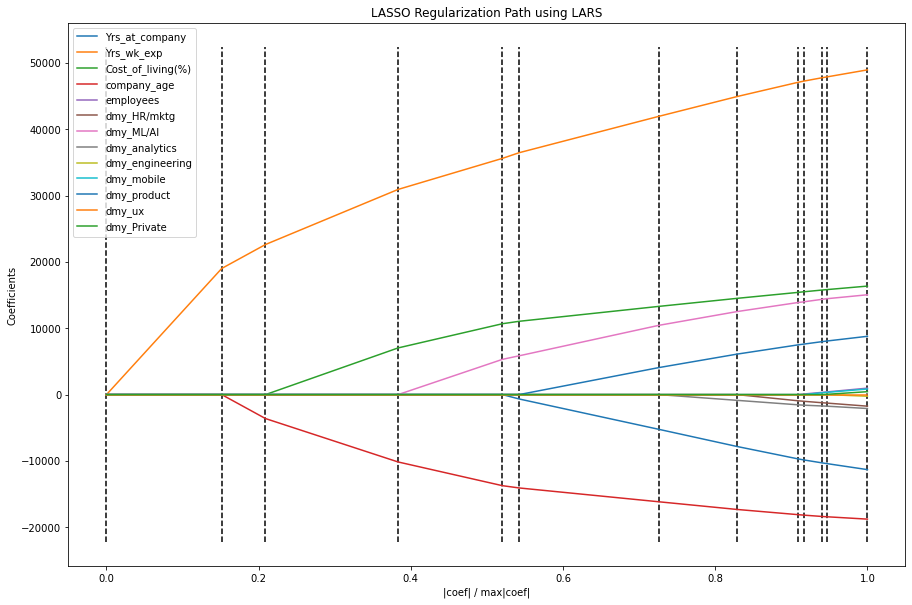

In [16]:
selected_columns = ['Yrs_at_company', 'Yrs_wk_exp', 'Cost_of_living(%)', 'company_age', 'employees', 'dmy_HR/mktg', 
                    'dmy_ML/AI', 'dmy_analytics','dmy_engineering', 'dmy_mobile', 'dmy_product', 'dmy_ux', 'dmy_Private']

plot_lars_path(X_train_scaled, y_train, selected_columns)

## Final testing!

In [17]:
check_shapes(X_train_val, y_train_val, X_test, y_test)

(526, 13)
(526,)
(132, 13)
(132,)


In [18]:
ridge_final = Ridge(alpha=ridge_alpha)
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_test_scaled = scaler.transform(X_test)
ridge_final.fit(X_train_val_scaled, y_train_val)
print(f'Ridge Regression final test R^2: {ridge_final.score(X_test_scaled, y_test):.3f}')

Ridge Regression final test R^2: 0.236


In [19]:
calculate_mae(ridge_final, X_test_scaled, y_test)

64014.188

## Interpreting Ridge model coefficient results
- Use standard deviations to return Ridge scaled coefficients to interpretable figures
- Ridge Regression coefficient results (from above):  
Yrs_at_company : -11196.81  
Yrs_wk_exp : 48758.44  
Cost_of_living(%) : 16315.26  
company_age : -18726.30  
employees : 971.08  
dmy_HR/mktg : -1740.18  
dmy_ML/AI : 14942.73  
dmy_analytics : -2117.41  
dmy_engineering : -273.95  
dmy_mobile : 833.20  
dmy_product : 8732.12  
dmy_ux : 0.00  
dmy_Private : 457.11  

In [20]:
df.std().round(2)

Yrs_at_company            2.48
Yrs_wk_exp                4.35
Total_comp           106916.36
Cost_of_living(%)        24.32
company_age              29.33
employees            357586.46
dmy_HR/mktg               0.07
dmy_ML/AI                 0.47
dmy_analytics             0.26
dmy_engineering           0.25
dmy_mobile                0.13
dmy_product               0.20
dmy_ux                    0.06
dmy_Private               0.24
dtype: float64

In [21]:
# Yrs_at_company : 
-11196.81/2.48

-4514.842741935484

In [22]:
# Yrs_wk_exp : 
48758.44/4.35

11208.836781609198

In [23]:
# Cost_of_living(%) : 
16315.26/24.32

670.8577302631579

In [24]:
# company_age : 
-18726.30/29.33

-638.4691442209343